# Microsoft Stocks Price Prediction (using FEDOT)

This notebook was was inspired by that [post](https://www.kaggle.com/paramarthasengupta/microsoft-stocks-price-prediction?select=Microsoft_Stock.csv) on Kaggle. 

In [ ]:
# We will use FEDOT framework version 0.3.1 for forecasting
pip install fedot==0.3.1

[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This notebook was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 


In [33]:
# Additional imports 
import pandas as pd 
import numpy as np

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

import warnings
warnings.filterwarnings('ignore')

## Exploratory visualizations 

In [34]:
df = pd.read_csv('Microsoft_Stock.csv', parse_dates=['Date'])
df.head(5)

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


Consider the closing price as the target variable. Show it on the plot

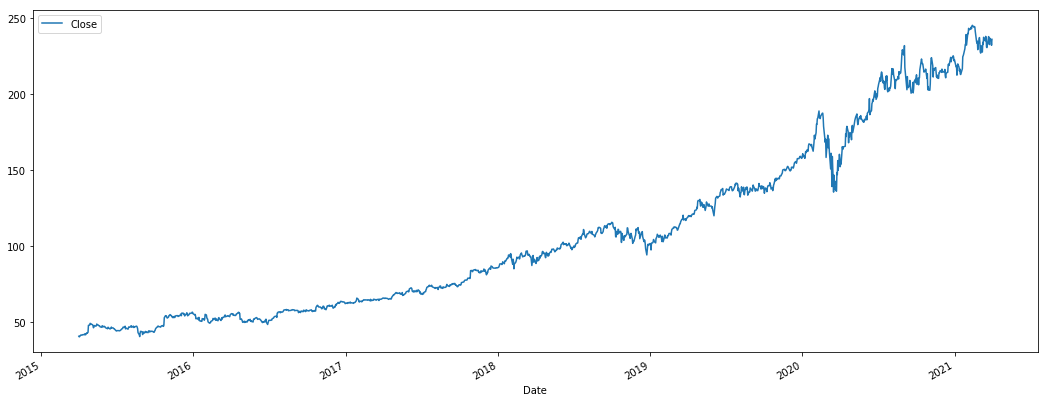

In [35]:
df.plot('Date', 'Close')
plt.show()

## Train test split

In [36]:
train_size = int(len(df)*0.75)
test_size = len(df) - train_size

The length of the forecast is equal to the length of the validation block

In [37]:
forecast_length = test_size

## AutmoML framework FEDOT

In [38]:
from fedot.api.main import Fedot

# Chain and nodes
from fedot.core.chains.chain import Chain
from fedot.core.chains.node import PrimaryNode, SecondaryNode

# Data 
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup
from fedot.core.repository.dataset_types import DataTypesEnum

# Tasks
from fedot.core.repository.tasks import Task, TaskTypesEnum, TsForecastingParams

# Metric
from sklearn.metrics import mean_absolute_error

In [39]:
task = Task(TaskTypesEnum.ts_forecasting,
            TsForecastingParams(forecast_length=forecast_length))

# Load data from csv file and wrap it into InputData structure
input_data = InputData.from_csv_time_series(task, 'Microsoft_Stock.csv', target_column='Close')

# Divide into train and test 
train_data, test_data = train_test_data_setup(input_data)

Launch AutmoML framework for two minutes

*Due to the specifics of the jupiter notebooks format, in order not to overload the page with unnecessary logs, we do not show the cell output below.

The log must starts with:
"Composition started. Parameters tuning: True. Set of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'ar', 'scaling', 'normalization', 'simple_imputation', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 2 min

Model composition started ..."

In [40]:
# Define parameters
task_parameters = TsForecastingParams(forecast_length=forecast_length)

# Init model for the time series forecasting
model = Fedot(problem='ts_forecasting', task_params=task_parameters)

# Run AutoML model design in the same way
chain = model.fit(features=train_data)

Composition started. Parameters tuning: True. Set of candidate models: ['linear', 'lasso', 'ridge', 'xgbreg', 'adareg', 'gbr', 'dtreg', 'treg', 'rfr', 'svr', 'sgdr', 'ar', 'scaling', 'normalization', 'simple_imputation', 'pca', 'poly_features', 'ransac_lin_reg', 'ransac_non_lin_reg', 'rfe_lin_reg', 'rfe_non_lin_reg', 'lagged', 'smoothing', 'gaussian_filter']. Composing time limit: 2 min
Model composition started
Hyperparameters tuning started
Default loss function was set
Hyperparameters optimization start
 10%|████▌                                         | 99/1000 [01:00<09:10,  1.64trial/s, best loss: 14.374979790005906]
Hyperparameters optimization finished
Return tuned chain due to the fact that obtained metric 14.375 equal or smaller than initial (+ 5% deviation) 15.508
Model composition finished


In [41]:
# Use model to obtain forecast
forecast = model.predict(features=test_data)

Prepare function for visualisation.

In [42]:
def display_results(actual_time_series, predicted_values, len_train_data, y_name = 'Microsoft Stocks Price'):
    """
    Function for drawing plot with predictions and check metrics
    
    :param actual_time_series: the entire array with one-dimensional data
    :param predicted_values: array with predicted values
    :param len_train_data: number of elements in the training sample
    :param y_name: name of the y axis
    """
    
    plt.plot(np.arange(0, len(actual_time_series)), 
             actual_time_series, label = 'Actual values', c = 'green')
    plt.plot(np.arange(len_train_data, len_train_data + len(predicted_values)), 
             predicted_values, label = 'Predicted', c = 'blue')
    # Plot black line which divide our array into train and test
    plt.plot([len_train_data, len_train_data],
             [min(actual_time_series), max(actual_time_series)], c = 'black', linewidth = 1)
    plt.ylabel(y_name, fontsize = 15)
    plt.xlabel('Time index', fontsize = 15)
    plt.legend(fontsize = 15, loc='upper left')
    plt.grid()
    plt.show()
    
    mae_value = mean_absolute_error(actual_time_series[len_train_data:], predicted_values)
    print(f'MAE value: {mae_value}')

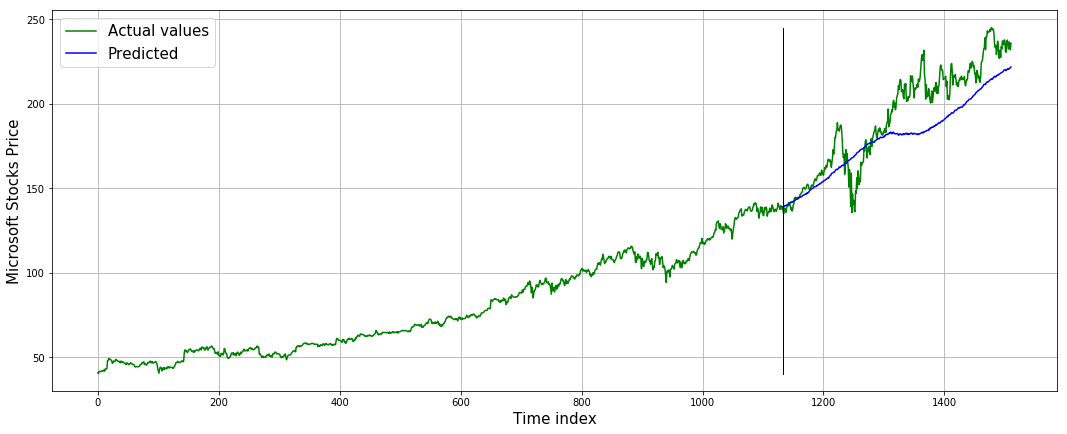

MAE value: 14.603718905999596


In [43]:
display_results(np.array(df['Close']), forecast, len(train_data.features))

Check obtained chain structure

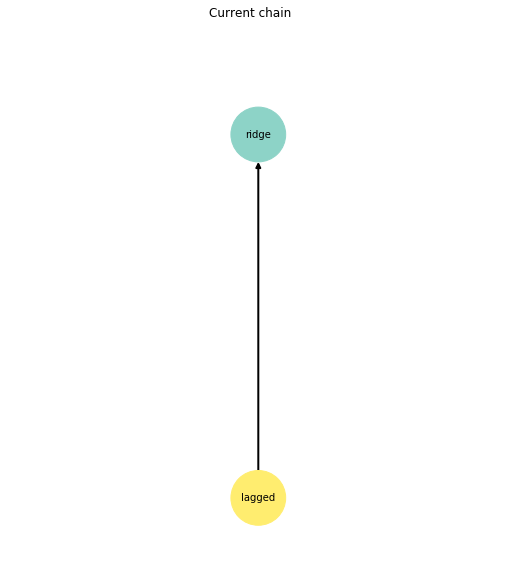

In [46]:
chain.show()